<a href="https://colab.research.google.com/github/AbdulQadir8/Langraph-Tutorial-Projects/blob/master/langraph_tutorial_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

In [142]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get("GEMINI_API_KEY")

In [143]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke('greet me')

AIMessage(content='Hello there! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-fe988302-2817-4c21-a4cb-f547babbd301-0', usage_metadata={'input_tokens': 3, 'output_tokens': 10, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [144]:
from typing import Annotated
from typing_extensions import TypedDict


from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
  # Messages have the type "list". The `add_messages` function
  # in the annotation defines how this state key should be updated
  # (in this case, it appends messages to the list, rather than overwriting them)
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [145]:
# Example usage of add_messages
new_messages_1 = [{"role": "user", "content": "Hello"}]
new_messages_2 = [{"role": "ai", "content": "Hi there!"}]

updated_state_1 = add_messages(new_messages_1, new_messages_2)


print("Updated State 1:", updated_state_1)

# from typing import Annotated
# from typing_extensions import TypedDict
# from langgraph.graph import StateGraph

# class State(TypedDict):
#     messages: Annotated[list, add_messages]

# builder = StateGraph(State)
# builder.add_node("chatbot", lambda state: {"messages": [("assistant", "Hello")]})
# builder.set_entry_point("chatbot")
# builder.set_finish_point("chatbot")
# graph = builder.compile()
# graph.invoke({"messages": [{"role": "user", "content": "Hello"}]})

Updated State 1: [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='89aabac2-3c0d-43a5-b496-7b7e36e428f9'), AIMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, id='c3e14cbe-fbde-401f-a67c-7c3bb4e511bc')]


So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.

Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.

In [146]:
def chatbot(state: State):
  return {"messages":[llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot",chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [147]:
graph_builder.add_edge(START, "chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node
is run, you can exit."**

In [148]:
graph_builder.add_edge("chatbot", END)

In [149]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw"

---

methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

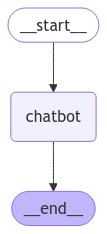

In [150]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except:
  # This requires some extra dependencies and is optional
  pass



In [167]:
for event in graph.stream({"messages":[("user","I am Abdul Qadir")]}):
  print("EVENT: ",list(event.values())[0]["messages"].content)

EVENT:  Nice to meet you, Abdul Qadir! How can I help you today? 



In [170]:
def stream_graph_updates(user_input: str):
  for event in graph.stream({"messages": [("user", user_input)]}):
    for value in event.values():
      print("Assistant", value["messages"])

while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit","exit","q"]:
      print("Good bye!")
      break
    stream_graph_updates(user_input)
  except:
    # fallback if input is not available
    user_input = "What do you know about LangGraph?"
    print("User: "+ user_input)
    stream_graph_updates(user_input)
    break

User: Who is Quaid-e-Azam?
Assistant content='' additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Who is Quaid-e-Azam?"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]} id='run-db68e16d-0853-4974-990d-d6dd45b272f6-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Who is Quaid-e-Azam?'}, 'id': '79f822c4-f4fa-4982-9d48-40b52b29f488', 'type': 'tool_call'}] usage_metadata={'input_tokens': 84, 'output_tokens': 29, 'total_tokens': 113, 'input_token_details': {'cache_read': 0}}

**Congratulations!** You've built your first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM. You can inspect a [LangSmith Trace](https://smith.langchain.com/public/7527e308-9502-4894-b347-f34385740d5a/r) for the call above at the provided link.

However, you may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

Below is the full code for this section for your reference:

<details>
<summary>Full Code</summary>
    <pre>
        
```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()
```

</pre>
</details>

## Part 2: Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

#### Requirements

Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the [Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

In [155]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [156]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

# Next define the tools

In [157]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("Whats the weather in Lahore Today?")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Lahore', 'region': 'Punjab', 'country': 'Pakistan', 'lat': 31.5497, 'lon': 74.3436, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1731146153, 'localtime': '2024-11-09 14:55'}, 'current': {'last_updated_epoch': 1731145500, 'last_updated': '2024-11-09 14:45', 'temp_c': 32.2, 'temp_f': 89.9, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 43, 'wind_dir': 'NE', 'pressure_mb': 1012.0, 'pressure_in': 29.87, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 22, 'cloud': 0, 'feelslike_c': 30.2, 'feelslike_f': 86.4, 'windchill_c': 32.2, 'windchill_f': 89.9, 'heatindex_c': 30.2, 'heatindex_f': 86.4, 'dewpoint_c': 7.7, 'dewpoint_f': 45.8, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 2.3, 'gust_mph': 2.3, 'gust_kph': 3.7}}"},
 {'url': 'https://world-weather.info/forecast/pakistan/lahore/september-2024/',
  'content

The results are page summaries our chat bot can use to answer questions.


Next, we'll start defining our graph. The following is all **the same as in Part 1**, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [158]:
from typing import Annotated
from typing_extensions import TypedDict


from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
  return {"messages": llm_with_tools.invoke((state["messages"]))}

graph_builder.add_node("chatbot",chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is instructive.

In [159]:
tools_by_name = {tool.name: tool for tool in tools}
print(type(tools_by_name))
print(tools_by_name)

tools_by_name["tavily_search_results_json"]

llm_with_tools.invoke("Who won in the 2024 Presidential elections?")

<class 'dict'>
{'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}


AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "2024 Presidential elections"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-be42e5c2-3dc8-43be-87fb-47c0a88f0da5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2024 Presidential elections'}, 'id': '776c9b16-ebc2-4175-aa44-0a66b717a7c5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 25, 'total_tokens': 111, 'input_token_details': {'cache_read': 0}})

In [160]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
  """A Node that runs the tools requested in the las AIMessage."""

  def __init__(self, tools: list) -> None:
    self.tools_by_name = {tool.name: tool for tool in tools}

  def __call__(self, inputs: dict):
    if messages := inputs.get("messages", []):
      message = messages[-1]
    else:
      raise ValueError("No messages found in input")
    outputs = []
    for tool_call in message.tool_calls:
      tool_result = self.tools_by_name[tool_call["name"]].invoke(
          tool_call["args"]
      )
      outputs.append(
          ToolMessage(
              content=json.dumps(tool_result),
              name=tool_call["name"],
              tool_call_id=tool_call["id"]
          )
      )

    return {"messages":outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools",tool_node)

In [161]:
from langchain_core.messages import HumanMessage, AIMessage

messages = [
AIMessage(content='',
          additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "2024 presidential elections polls"}'}},
          response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []},
          id='run-621e608b-24ae-4d50-8605-33415037f7df-0',
          tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2024 presidential elections polls'}, 'id': '826c7148-a96a-4f79-9c64-325c97489d5e', 'type': 'tool_call'}],
          usage_metadata={'input_tokens': 90, 'output_tokens': 16, 'total_tokens': 106, 'input_token_details': {'cache_read': 0}})
]

tool_node(inputs={"messages": messages})

{'messages': [ToolMessage(content='[{"url": "https://projects.fivethirtyeight.com/2024-election-forecast/", "content": "With the 2024 presidential election a week away, 538\'s Galen Druke and G. Elliott Morris discuss the relevancy of early voting data. October 29, 2024. The 2024 election could hinge on Pennsylvania. ... What the polls say about the 2024 election."}, {"url": "https://www.bbc.com/news/articles/cj4x71znwxdo", "content": "US election polls 2024: Who is ahead - Harris or Trump? US election polls: Who is ahead - Harris or Trump? In a sign of how the race has changed since Harris became the Democratic nominee, on the day Joe Biden quit the race he was trailing Trump by nearly five percentage points on average in these seven battleground states. At the moment, the polls suggest that Kamala Harris and Donald Trump are within a couple of percentage points of each other both nationally and in battleground states - and when the race is that close, it\\u2019s very hard to predict 

With the tool node added, we can define the `conditional_edges`.

Recall that **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and `END` if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, but implementing it ourselves first makes things more clear.

In [162]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the '`chatbot`' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

Like the prebuilt `tools_condition`, our function returns the `END` string if no tool calls are made. When the graph transitions to `END`, it has no more tasks to complete and ceases execution. Because the condition can return `END`, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

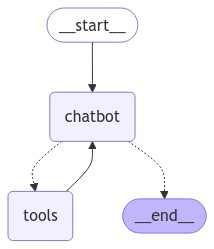

In [163]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
      # This requires some extra dependencies and is optional
      pass

Now we can ask the bot questions outside its training data.

---



In [164]:
while True:
  try:
    user_input = input()
    if user_input.lower() in ["exit","quit","q"]:
      print("Good bye!")
      break
    stream_graph_updates(user_input)
  except:
    # fallback if input() is not available
    user_input = "What do you about LangGraph?"
    print("User: "+ user_input)
    stream_graph_updates(user_input)
    break

Who won US 2024 elections?
Assistant content='' additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Who won US 2024 elections?"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]} id='run-06591749-3400-4938-a45e-3fa1882a0198-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Who won US 2024 elections?'}, 'id': '1a4ddef8-8750-4ea1-98a7-7c2039c09620', 'type': 'tool_call'}] usage_metadata={'input_tokens': 84, 'output_tokens': 29, 'total_tokens': 113, 'input_token_details': {'cach